In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("train.csv")

In [5]:
# drop missing questions 
df.dropna(inplace=True)
print(df.isna().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [6]:
q1 = df['question1']
q2 = df['question2']

In [7]:
import re

from nltk.corpus import stopwords
engStopWords = stopwords.words('english')

import string
puncts = string.punctuation

from nltk import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

In [8]:
def del_stopWords(text):
    word_list = text.split()
    text =" ".join([word for word in word_list if word not in engStopWords])
    return text

def del_punct(text):
    text="".join([char for char in text if char not in puncts])
    return text

def lem_text(text):
    word_list = text.split()
    text=" ".join([lemmatizer.lemmatize(word) for word in word_list])
    return text

In [9]:
def preprocess_text(text_list):
    text_clean=[]
    for text in text_list:
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text) # remove urls
        text = re.sub(r'<.*?>', '', text) # remove htmls
        text = del_punct(text)
        text = del_stopWords(text)
        text = lem_text(text)
        text = re.sub(r'\s+', ' ', text).strip()
        text_clean.append(text)
    return text_clean

In [10]:
q1_train_clean = preprocess_text(q1)
q2_train_clean = preprocess_text(q2)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
questions = q1_train_clean + q2_train_clean

In [13]:
tf_vectorizer = TfidfVectorizer(max_features=1000, analyzer='char', ngram_range=(2,3), use_idf=True, min_df=5, max_df=0.9)

In [14]:
tf_vectorizer.fit(questions)

TfidfVectorizer(analyzer='char', max_df=0.9, max_features=1000, min_df=5,
                ngram_range=(2, 3))

In [15]:
q1_vect = tf_vectorizer.transform(q1_train_clean)
q2_vect = tf_vectorizer.transform(q2_train_clean)

In [16]:
import scipy
from sklearn.model_selection import train_test_split

In [17]:
X = scipy.sparse.hstack((q1_vect,q2_vect))

In [18]:
y = df['is_duplicate'].values

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 15, stratify=y)

In [20]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [27]:
xgb = XGBClassifier(
    max_depth=50,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=0.8,
    objective='binary:logistic'
)

In [28]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
yhat_xgb = xgb.predict(X_test)

In [31]:
print(classification_report(y_test, yhat_xgb))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     76508
           1       0.83      0.64      0.72     44779

    accuracy                           0.82    121287
   macro avg       0.82      0.78      0.79    121287
weighted avg       0.82      0.82      0.81    121287



In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
cm = confusion_matrix(y_test, yhat_xgb)

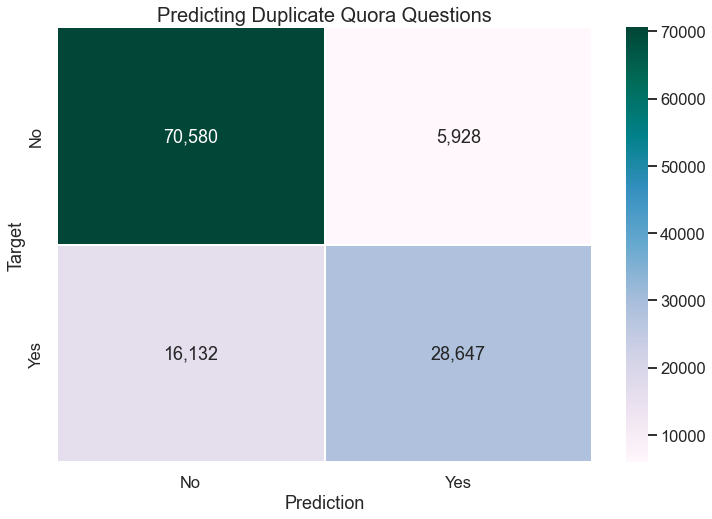

In [65]:
with sns.plotting_context('talk'):
    ax = sns.heatmap(cm, annot=True, cmap='PuBuGn', linewidths=2, linecolor='white', fmt=",g")
    plt.xlabel('Prediction')
    ax.set_xticklabels(['No','Yes'])
    ax.set_yticklabels(['No','Yes'])
    sns.set(rc={'figure.figsize':(12,8)})
    plt.ylabel('Target')
    plt.title('Predicting Duplicate Quora Questions', fontsize=20)
    plt.savefig('confusion_matrix_charLevel.png')
    plt.show()

In [73]:
params={
    'max_depth':[50,100],
    'n_estimators':[100, 200],
}

    # 'learning_rate':[0.1, 0.3]

In [74]:
grid = GridSearchCV(XGBClassifier(objective='binary:logistic', colsample_bytree=0.8, learning_rate=0.1), param_grid=params, scoring='recall', n_jobs=-1)

In [77]:
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [76]:
print(grid.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'